# Live Auction Clean

Recently the human bidders on the site are becoming increasingly frustrated with their inability to win auctions vs. robots. In order to rebuild customer happiness, the company is seeking to eliminate robot bidders from the site.

The goal of this project is to provide Live Auction with a model that will identify and flag bidders if they are a robot and prevent unfair bidding activity.

This notebook is the cleaned up, functionized version

In [2]:
################################## Imports ########################################################

# Basic Imports
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import time
import datetime

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Model Infrastructure
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.utils import resample
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import cross_val_predict
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

import boto3
import io

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble

In [3]:
#################################### Bring in Data ################################################
start_time = time.time()
s3 = boto3.client('s3')

#Bring in Training Data
obj = s3.get_object(Bucket='data-science-project-data', Key='Human_or_Robot/train.csv')
train = pd.read_csv(io.BytesIO(obj['Body'].read()))
train.set_index('bidder_id', inplace=True)

# Bring in bids data
obj = s3.get_object(Bucket='data-science-project-data', Key='Human_or_Robot/bids.csv')
bids = pd.read_csv(io.BytesIO(obj['Body'].read()))

print("-- Execution time: %s seconds ---" % (time.time() - start_time))

-- Execution time: 22.76021385192871 seconds ---


In [31]:
###################################### Functions #################################################

#Create function to time into a real time stamp. Assuming min_time_diff is a second.
def convert_time(time):
    min_time_diff = 52631579
    #Time in seconds of 1/1/2010 12:00AM since 1970
    init_seconds = 1262347200
    #Minimum value from dataset
    min_time = 9631916842105263

    b = init_seconds - (1/min_time_diff)*min_time
    timestamp = (1/min_time_diff)*time + b
    return datetime.datetime.fromtimestamp(timestamp)


########## Create the bids dataframe ################
def create_bid_dataframe(data):
    # Create converted Time column
    data['Converted Time'] = data['time'].apply(lambda x: convert_time(x))
    
    # Create bidder aggregation
    bidder_aggregate = data.groupby(['bidder_id'])['bid_id'].count().to_frame()
    bidder_aggregate.columns = ['Total Bids']
    bidder_aggregate['Total Auctions'] = data.groupby(['bidder_id'])['auction'].nunique()
    bidder_aggregate['Number of Merchandise'] = data.groupby(['bidder_id'])['merchandise'].nunique()
    bidder_aggregate['Number of Device'] = data.groupby(['bidder_id'])['device'].nunique()
    bidder_aggregate['Number of IPs'] = data.groupby(['bidder_id'])['ip'].nunique()
    bidder_aggregate['Number of URLs'] = data.groupby(['bidder_id'])['url'].nunique()
    
    # Create Bidder Auction Dataframe
    bidder_auction = data.groupby(['bidder_id','auction'])['Converted Time'].min().to_frame()
    bidder_auction.columns = ['First Bid Time']
    bidder_auction['Last Bid Time'] = data.groupby(['bidder_id','auction'])['Converted Time'].max().to_frame()
    bidder_auction['Bid Time Difference'] = bidder_auction['Last Bid Time'] - bidder_auction['First Bid Time']
    bidder_auction['Number of Bids'] = data.groupby(['bidder_id','auction'])['time'].count().to_frame()
    bidder_auction['Mean Time per Bid'] = bidder_auction['Bid Time Difference']/bidder_auction['Number of Bids']
    
    # Creat Auction Dataframe
    auction = data.groupby(['auction'])['Converted Time'].min().to_frame()
    auction.columns = ['Auction Started']

    #Create other columns
    auction['Auction Ended'] = data.groupby(['auction'])['Converted Time'].max().to_frame()
    auction['Auction Time Difference'] = auction['Auction Ended'] - auction['Auction Started']
    auction['Number of Bidders'] = data.groupby(['auction'])['bidder_id'].nunique().to_frame()
    
    # Join Auction with Bidder_auction
    bidder_auction_full = bidder_auction.join(auction, how='inner')
    #Particpation measure. How much of the auction particpated in (time)
    bidder_auction_full['Time Particpation'] = (((bidder_auction_full['Auction Ended'] 
                                                 - bidder_auction_full['First Bid Time'])/bidder_auction_full['Auction Time Difference']))*100
    # Started ratio (When got in the higher the number the later)
    bidder_auction_full['Started Ratio'] = (((bidder_auction_full['First Bid Time'] 
                                                     - bidder_auction_full['Auction Started'])/bidder_auction_full['Auction Time Difference']))*100
    # Won Auction
    bidder_auction_full['Won Auction'] = bidder_auction_full['Last Bid Time']==bidder_auction_full['Auction Ended']
    
    # Now time to aggregate
    bidder_auction_full_aggregate = bidder_auction_full.groupby(['bidder_id'])['Mean Time per Bid'].min().to_frame()
    bidder_auction_full_aggregate.columns = ['Min Mean Time per Bid']
    bidder_auction_full_aggregate['Max Mean Time per Bid'] = bidder_auction_full.groupby(['bidder_id'])['Mean Time per Bid'].max().to_frame()
    bidder_auction_full_aggregate['Min Time Particpation'] = bidder_auction_full.groupby(['bidder_id'])['Time Particpation'].min().to_frame()
    bidder_auction_full_aggregate['Max Time Particpation'] = bidder_auction_full.groupby(['bidder_id'])['Time Particpation'].max().to_frame()
    bidder_auction_full_aggregate['Mean Time Particpation'] = bidder_auction_full.groupby(['bidder_id'])['Time Particpation'].mean().to_frame()
    bidder_auction_full_aggregate['Min Started Ratio'] = bidder_auction_full.groupby(['bidder_id'])['Started Ratio'].min().to_frame()
    bidder_auction_full_aggregate['Max Started Ratio'] = bidder_auction_full.groupby(['bidder_id'])['Started Ratio'].max().to_frame()
    bidder_auction_full_aggregate['Mean Started Ratio'] = bidder_auction_full.groupby(['bidder_id'])['Started Ratio'].mean().to_frame()
    bidder_auction_full_aggregate['Auctions Won'] = bidder_auction_full[bidder_auction_full['Won Auction']==True].groupby(['bidder_id'])['Won Auction'].count().to_frame()
    bidder_auction_full_aggregate.fillna(0, inplace=True)
    
    # Joing to bidder aggregate
    bidder_features = bidder_aggregate.join(bidder_auction_full_aggregate, how='inner')
    
    #Convert Time Delta to seconds
    bidder_features['Max Mean Time per Bid'] = bidder_features['Max Mean Time per Bid'].apply(lambda x: x.total_seconds())
    bidder_features['Min Mean Time per Bid'] = bidder_features['Min Mean Time per Bid'].apply(lambda x: x.total_seconds())
    
    return bidder_features
    

############### Join the bidder_feature ##################

def add_features(train, features):
    return train.join(features, how='inner')


################# Data Split #############################
def train_split(train, split_percent, minority_upsample):
    # Create initial x and y
    y = train['outcome']
    X = train.drop(['payment_account','address'],1)

    # Split the Data 
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=split_percent)

    # Drop outcome from X_test
    X_test = X_test.drop(['outcome'],1)

    # Do the upsample on the X_train
    df_majority = X_train[X_train.outcome==0]
    df_minority = X_train[X_train.outcome==1]
    
    # Upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,     # sample with replacement
                                     n_samples=minority_upsample,    # to match majority class
                                     random_state=123) # reproducible results

    # Combine majority class with upsampled minority class
    df_upsampled = pd.concat([df_majority, df_minority_upsampled])

    # Rename the X_train and y_train
    X_train = df_upsampled.drop(['outcome'],1)
    y_train = df_upsampled['outcome']
    
    return X_train, X_test, y_train, y_test


######### Separate Outcome feature split ########################
def outcome_feature_split(train):
    y = train['outcome']
    X = train.drop(['outcome','payment_account','address'],1)
    

In [32]:
###################### Assemble Data ########################################
start_time = time.time()

# Create Bidder Features
bidder_features = create_bid_dataframe(bids)

#Create Training Set
training_set = add_features(train, bidder_features)

# Perform Test train split
X_train, X_test, y_train, y_test = train_split(training_set, 0.3, 90)

print("-- Execution time: %s seconds ---" % (time.time() - start_time))

-- Execution time: 78.53564286231995 seconds ---


In [33]:
####################### Model ################################################

#Will use Grid Search to do the cross validation.
start_time = time.time()
parameters = {'subsample':[0.95],
              'max_depth':[2],
             'n_estimators':[500]}

# Initialize the model.
clf = ensemble.GradientBoostingClassifier(max_depth=2,loss='deviance')

#Create grid and perform 5 cross validation
gradient_grid = GridSearchCV(clf, parameters, cv=8, verbose=0, scoring='roc_auc')

#Fit the Data
gradient_grid.fit(X_train, y_train)
print("--- %s seconds ---" % (time.time() - start_time))


#  Test Score
gradient_prediction = gradient_grid.predict(X_test)

gradient_prediction_proba = gradient_grid.predict_proba(X_test)
gradient_prediction_proba = [p[1] for p in gradient_prediction_proba]

# Produce the AUROC
print(roc_auc_score(y_test, gradient_prediction_proba))

--- 4.298190116882324 seconds ---
0.9125744308231174


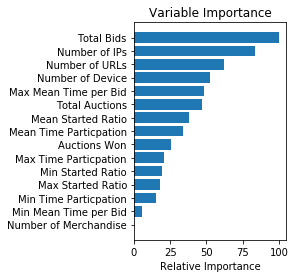

In [28]:
################ Plot Feautre Importance ######################################
feature_importance = gradient_grid.best_estimator_.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()